# Style transfer

В этом задании вы реализуете алгоритм переноса стиля. По сути, вам нужно просто объеденить тетрадки из прошлых двух уроков в одну.

In [1]:
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm_notebook as tqdm

2024-02-03 00:33:37.524897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 00:33:37.524918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 00:33:37.524923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 00:33:37.529194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import  Path

### Algorithm based on VGG19 model
Let's see summary of this model. Useful info - layer_names

In [3]:
vgg = tf.keras.applications.VGG19()
vgg.summary()

2024-02-03 00:31:01.695188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 00:31:01.780729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 00:31:01.784690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [3]:
def clip_0_1(image):
    """
    clip result image values between 0 and 1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    load image and reshape it
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1

    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    show img function
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.axis('off')
    plt.imshow(image)
    if title:
        plt.title(title)

def show_pair(original, generated, title=None):
    """
    show pair of original and generated image
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

In [4]:
def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    """
    computation of Gram-martix
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)

    num_locations = tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
    return result/(num_locations)

## Definition of feature Extractor

StyleAndContentExtractor`, receives layer names at the input, which we are going to extract from image for Style-LOSS (`style_layers`) and for Content-LOSS (`content_layers`).

Mathod `__call__(self, inputs)` receives an image at input, returns Dict():
```
{
    "style"   {"layer name": Gram matrix of the iutput from this layer for image at inputs, ...},
    "content" {"layer name": activation of this layer for inputs}
 }

```

In [5]:
class StyleAndContentExtractor:
    def __init__(self, style_layers, content_layers):
        """
        style_layers   -- list of layer names for STYLE
        content_layers -- list of layer lames for CONTENT
        
        """
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg_outputs_model = None
        self.vgg_outputs_model = get_vgg_layers_model(style_layers + content_layers)
        self.vgg_outputs_model.trainable = False

    def __call__(self, inputs):
        """
        Input is 4D tensor (image). Pixel values are limited between 0..1!

        Output   : {
            "style" : {
                        "layer_name_1": gram matrix of the output from this layer for image (at inputs)
                        "layer_name_2": ...,
                        "layer_name_3": ...
                        },
            "content" {
                        "layer_name_1": activations of this layer for image (at inputs) 
                        "layer_name_2": ...,
                        "layer_name_3": ...
                      }
                    }

        """
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG preprocess
        outputs = self.vgg_outputs_model(preprocessed_input)
        features_dict = {}


        # computation of Gram matrices for every layer
        style_outputs = [gram_matrix(style_output)
                        for style_output in outputs[ : len(self.style_layers)]
                        ]

        # computation of content outputs - for top layers only
        content_outputs = [content_output
                        for content_output in outputs[ - len(self.content_layers) : ]
                          ]

        features_dict["style"] = {name:value for name, value in zip(self.style_layers, style_outputs)}
        features_dict["content"] = {name:value for name, value in zip(self.content_layers, content_outputs)}    

        return features_dict

## Definition of the Style-transferer

In [6]:
class Style_transfer_optimizer:
    def __init__(self, style_image, content_image, extractor, num_epochs = 20, steps_per_epoch = 50):
        self.style_image = style_image
        self.content_image = content_image

        self.image = tf.Variable(self.content_image) # variable
        
        self.extractor = extractor
        self.style_targets = extractor(style_image)['style']
        self.content_targets = extractor(content_image)['content']

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        self.epochs = num_epochs # 20
        self.steps_per_epoch = steps_per_epoch # 50



    def style_content_loss(self):
        """
        content_targets/style_targets -- {"layer_name": layer output/Gram matrix, ...}
        
        """
        style_weight = 100.0
        content_weight = 5.0
        tv_weight = 0.1
        
        style_loss = None
        content_loss = None
    
        current_features = self.extractor(self.image)
    
        # define loss object as MSE
        mse_loss = tf.keras.losses.MeanSquaredError()
        
        # calculate STYLE loss
        style_loss = tf.add_n([mse_loss(current_features["style"][name], self.style_targets[name])
                                         for name in current_features["style"].keys()])
    
        style_loss *= 1. / len(self.style_targets)   
        
    
        # calculate CONTENT loss
        content_loss = tf.add_n([mse_loss(current_features["content"][name], self.content_targets[name])
                                         for name in current_features["content"].keys()])
    
        content_loss *= 1. / len(self.content_targets)
    
        # result loss
        loss = style_weight * style_loss + content_weight * content_loss + tv_weight * tf.image.total_variation(self.image)
        return loss
    

    def train_step(self):
        """
        Implementation of the Train step without .fit()
        
        """
    
        with tf.GradientTape() as tape: # "recording" the gradients for following usage
            loss = self.style_content_loss()
        grad = tape.gradient(loss, self.image) # dLoss/dImage
        self.optimizer.apply_gradients([(grad, self.image)]) # step of gradient descent.  GD: image = image - lambda*dLoss/dImage
                                             
        self.image.assign(clip_0_1(self.image)) #  image = clip_0_1(image), clipping of incorrect values 
        return loss.numpy()


    def optimize(self):        
        step = 0
        for n in range(self.epochs):
          for m in tqdm(range(self.steps_per_epoch)):
            step += 1
            self.train_step()
        
          display.clear_output(wait=True)
          show_pair(self.content_image, self.image, f"Generated Image.Train step: {step}")
          # plt.imsave(f"{content_name}@{style_name}_{step}.png", image.numpy()[0])
          plt.show()



### Definition of Global parameters
### Creation of Global Objects

In [30]:
# Define layers for content and style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]
content_layers = ['block5_conv2']

# Create the Feature-Extractor object
extractor = StyleAndContentExtractor(style_layers=style_layers, content_layers=content_layers)


# LOAD IMAGES
content_path = 'content_5.jpg'
style_path = 'style_1.jpg'

content_image = load_img(content_path, 1024)
style_image = load_img(style_path, 1024)


# Create Style_transfer_optimizer object
style_transferer = Style_transfer_optimizer(style_image = style_image,
                                            content_image = content_image,
                                            extractor = extractor,
                                            num_epochs = 20, # 20,
                                            steps_per_epoch = 50 # 50    
                                            )

### Preview of source images

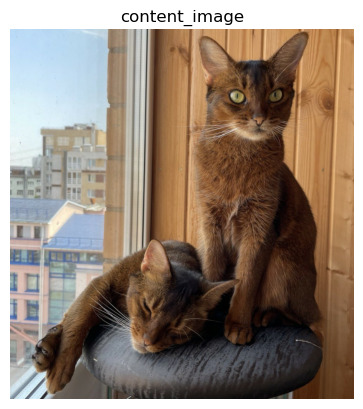

In [31]:
imshow(content_image, title= 'content_image')

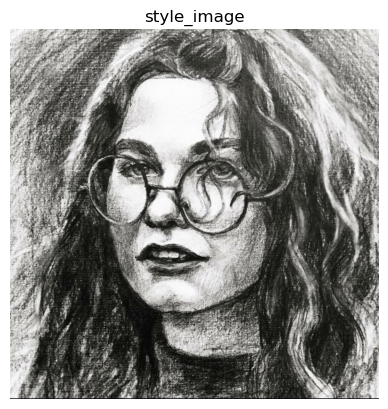

In [32]:
imshow(style_image, title= 'style_image')

### Run optimization

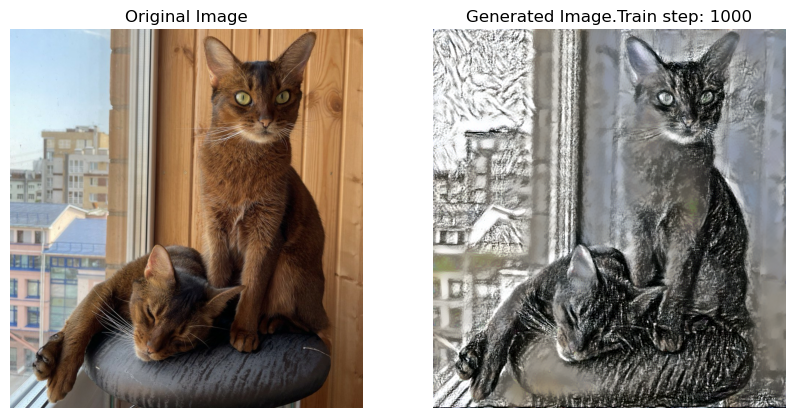

In [33]:
style_transferer.optimize()